# Strategy details

This strategy is based on the followin paper:
ASNESS, C.S., MOSKOWITZ, T.J. and PEDERSEN, L.H. (2013), Value and Momentum Everywhere. The Journal of Finance, 68: 929-985. https://doi.org/10.1111/jofi.12021

In which the authors use a classic value and momentum strategy. The idea is that

"For momentum, we use the common measure of the past 12-month cumulative raw return on the asset, skipping the most recent month's return, MOM2–12. We skip the most recent month, which is standard in the momentum literature, to avoid the 1-month reversal in stock returns, which may be related to liquidity or microstructure issues"

In [64]:
# Collect the list of the S&P 500 companies from Wikipedia and save it to a file
import os
import requests
import pandas as pd

# Get the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content
df = pd.read_html(html, header=0)[0]

tickers = df['Symbol'].tolist()

In [65]:
# Load the data from yahoo finance
import os
import yfinance as yf

def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2023-12-31')

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        holder.append(df)
        ticker_with_data.append(symbol)

tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')


BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 2005-01-01 -> 2023-12-31)
GEV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800
SOLV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800


Loaded data for 499 companies


In [66]:
# We only need the monthly data, so we will resample the data,
# Open should be the first day of the month, Close should be the last day of the month
# High should be the maximum value of the month, Low should be the minimum value of the month
monthly_data = []
for data in holder:
    df = data.resample('M').agg({
        'date': 'first',
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    df.set_index('date', inplace=True)

    monthly_data.append(df)

del holder

### Adding the factor and monthly return
Assuming the we will open at the monthly open price and will close at the monthly close

In [67]:
import numpy as np
from multiprocessing import Pool

def process_data(df):
    
    df['intra_month_return'] = df['Close'] / df['Open'] - 1
    df['next_month_return'] = df['intra_month_return'].shift(-1)
    
    df['monthly_return'] = df['Close'].pct_change()

    # Last 12 months return except the current month
    df['rolling_12_months_return'] = df['Close'].pct_change().rolling(11).sum().shift()

    return df

n_cores = min(os.cpu_count()-2, len(monthly_data))
with Pool(n_cores) as p:
    monthly_data = p.map(process_data, monthly_data)


### Conduct regression analysis to find the significance of the factor

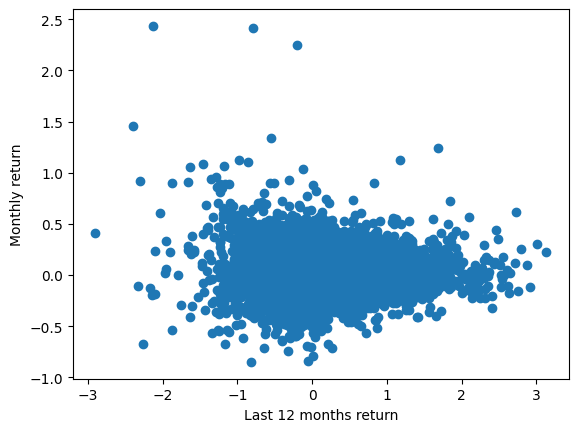

                            OLS Regression Results                            
Dep. Variable:      next_month_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     63.48
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.63e-15
Time:                        10:44:48   Log-Likelihood:             1.0903e+05
No. Observations:               96069   AIC:                        -2.180e+05
Df Residuals:                   96067   BIC:                        -2.180e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [68]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

holder = []
for df in monthly_data:
    holder.append(df[['rolling_12_months_return', 'next_month_return', 'monthly_return']].dropna())

df_for_regression = pd.concat(holder, axis=0, ignore_index=True)

plt.scatter(df_for_regression['rolling_12_months_return'], df_for_regression['next_month_return'])
plt.xlabel('Last 12 months return')
plt.ylabel('Monthly return')
plt.show()

# Clearly, we have some outliers and we need to get rid of them

# Clean the data from outliers. Keep the data within 5 standard deviations
mask_next_month_return = (np.abs(df_for_regression['next_month_return'] - df_for_regression['next_month_return'].mean()) < 3 * df_for_regression['next_month_return'].std())
mask_rolling_12_months_return = (np.abs(df_for_regression['rolling_12_months_return'] - df_for_regression['rolling_12_months_return'].mean()) < 3 * df_for_regression['rolling_12_months_return'].std())

df_for_regression = df_for_regression[
    mask_next_month_return & mask_rolling_12_months_return
]

X = sm.add_constant(df_for_regression['rolling_12_months_return'])
y = df_for_regression['next_month_return']

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

# Analysis of the results:

1- The p-value of the coefficient of the rolling 12 months return is 0.0, which means that the coefficient is statistically significant.

2- The coefficient is negative and is against the momentum effect, which means that the stocks that have performed well in the past 12 months tend to under perform in the next month.


### Possible reasons for the negative coefficient:

1- There's a mistake in the code. Please let me know if you find any to make the code correct.

2- Our universe is S&P 500, which is a large-cap index of the time that you run the code.
   There's a possibility that the momentum effect is not valid for large-cap stocks.

3- The time period that we used for the analysis is different from the time period that the momentum effect was found in the literature.

4- Maybe the effect is gone and not tradable anymore.

5- Maybe the effect can be found in the tails.


# What to do now?
Let's do the regression on the tails for each month. It means, that we may see the effect for the largest growths and largest declines.

In [69]:
rolling_12_months_return_holder = []
next_month_return_holder = []
monthly_return_holder = []

# Creating tables with symbols as columns and the data as rows
first = True
for symbol, df in zip(tickers, monthly_data):

    rolling_12_months_return_series = df['rolling_12_months_return'].copy().dropna()
    next_month_return_series = df['next_month_return'].copy().dropna()
    monthly_return = df['monthly_return'].copy().dropna()

    rolling_12_months_return_series.name = symbol
    next_month_return_series.name = symbol
    monthly_return.name = symbol

    rolling_12_months_return_holder.append(rolling_12_months_return_series)
    next_month_return_holder.append(next_month_return_series)
    monthly_return_holder.append(monthly_return)

rolling_12_months_return_df = pd.concat(rolling_12_months_return_holder, axis=1, ignore_index=False)
rolling_12_months_return_df.fillna(0, inplace=True)
next_month_return_df = pd.concat(next_month_return_holder, axis=1, ignore_index=False)
monthly_return_df = pd.concat(monthly_return_holder, axis=1, ignore_index=False)

print (rolling_12_months_return_df.iloc[:5, :5])
print (next_month_return_df.iloc[:5, :5])
print (monthly_return_df.iloc[:5, :5])


# Symbols to long and short
N = 20
long_df = rolling_12_months_return_df[(rolling_12_months_return_df > 0)]
short_df = rolling_12_months_return_df[(rolling_12_months_return_df < 0)]

long_df = long_df.mask(long_df.rank(axis=1, method='dense', ascending=False) > N, np.nan)
short_df = short_df.mask(short_df.rank(axis=1, method='dense', ascending=True) > N, np.nan)

long_df_symbols = long_df.apply(lambda row: row.dropna().index.tolist(), axis=1)
short_df_symbols = short_df.apply(lambda row: row.dropna().index.tolist(), axis=1)



                                MMM       AOS       ABT  ABBV       ACN
date                                                                   
2006-01-03 00:00:00-05:00 -0.047072  0.314974 -0.099370   0.0  0.135571
2006-02-01 00:00:00-05:00 -0.109366  0.577853 -0.019359   0.0  0.246903
2006-03-01 00:00:00-05:00 -0.111008  0.553795 -0.009187   0.0  0.337536
2006-04-03 00:00:00-04:00  0.025126  0.701410 -0.108465   0.0  0.359683
2006-05-01 00:00:00-04:00  0.144874  0.502169 -0.076305   0.0  0.253616
                                MMM       AOS       ABT  ABBV           ACN
date                                                                       
2005-01-03 00:00:00-05:00  0.001122 -0.032400  0.021546   NaN  1.522877e-08
2005-01-21 00:00:00-05:00       NaN       NaN       NaN   NaN           NaN
2005-02-01 00:00:00-05:00  0.020726  0.096468  0.013699   NaN -5.590336e-02
2005-03-01 00:00:00-05:00 -0.110814 -0.006883  0.055816   NaN -1.309570e-01
2005-04-01 00:00:00-05:00  0.008934  0.0

In [70]:
# Find the values of each ticker the long and short in rolling_12_months_return_df and next_month_return_df
# and flatten them for a regression
mask = long_df.notna() | short_df.notna()
rolling_12_months_return_df_for_regression = rolling_12_months_return_df[mask]
next_month_return_df_for_regression = next_month_return_df[mask]

# Flatten the data
rolling_12_months_return_holder = []
next_month_return_holder = []

for i in range(len(rolling_12_months_return_df_for_regression)):
    rolling_12_months_return_holder.extend(rolling_12_months_return_df_for_regression.iloc[i].tolist())
    next_month_return_holder.extend(next_month_return_df_for_regression.iloc[i].tolist())

rolling_12_months_return_df_for_regression = pd.Series(rolling_12_months_return_holder)
next_month_return_df_for_regression = pd.Series(next_month_return_holder)

rolling_12_months_return_df_for_regression.name = 'rolling_12_months_return'
next_month_return_df_for_regression.name = 'next_month_return'

df_for_regression = pd.concat([rolling_12_months_return_df_for_regression, next_month_return_df_for_regression], axis=1)
df_for_regression = df_for_regression.dropna()

X = sm.add_constant(df_for_regression['rolling_12_months_return'])
y = df_for_regression['next_month_return']

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:      next_month_return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.692
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.194
Time:                        10:44:48   Log-Likelihood:                 366.07
No. Observations:                 887   AIC:                            -728.1
Df Residuals:                     885   BIC:                            -718.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

# Analysis of the results

Although the p-value is not significant statistically, we can see a positive relationship between the rolling 12 months return and next month return on the tails.

That's a good sign, it means we can trade  momentum factor cross sectionally. At least we can give it a shot.

Sharpe ratio: -0.009481


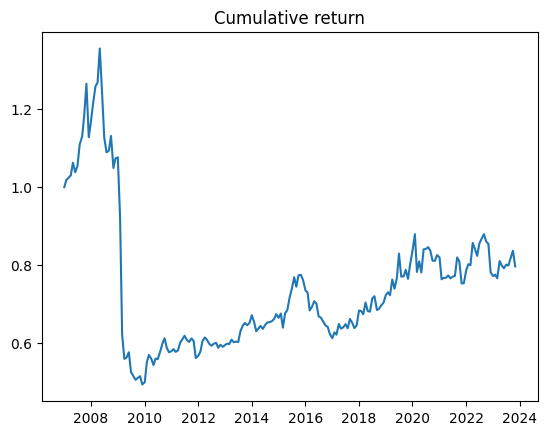

In [71]:
dates_holder = []
strategy_monthly_return_holder = []

for date, long_symbols, short_symbols in zip(long_df.index, long_df_symbols, short_df_symbols):

    monthly_return_tmp_holder = []

    for symbol in long_symbols:
        if date not in next_month_return_df.index:
            continue
        monthly_return_tmp_holder.append(next_month_return_df.loc[date, symbol])

    for symbol in short_symbols:
        if date not in next_month_return_df.index:
            continue
        monthly_return_tmp_holder.append(-next_month_return_df.loc[date, symbol])

    if len(monthly_return_tmp_holder) == 0:
        continue

    dates_holder.append(date)
    strategy_monthly_return_holder.append(np.mean(monthly_return_tmp_holder))

# Skipping the first 12 months because of the rolling 12 months return
n_cut = 12
dates_holder = dates_holder[n_cut:]
strategy_monthly_return_holder = strategy_monthly_return_holder[n_cut:]

# Find the cumsum of the strategy return
strategy_monthly_return_holder_cum = np.array(strategy_monthly_return_holder)
strategy_monthly_return_holder_cum = strategy_monthly_return_holder_cum + 1
strategy_monthly_return_holder_cum = np.cumprod(strategy_monthly_return_holder_cum)

sharpe = np.mean(strategy_monthly_return_holder) / np.std(strategy_monthly_return_holder) * np.sqrt(12)

print(f'Sharpe ratio: {sharpe:4f}')

plt.plot(dates_holder, strategy_monthly_return_holder_cum)
plt.title('Cumulative return')
plt.show()


# The sharpe ratio after financial crisis

Sharpe ratio after 2010: 0.370491


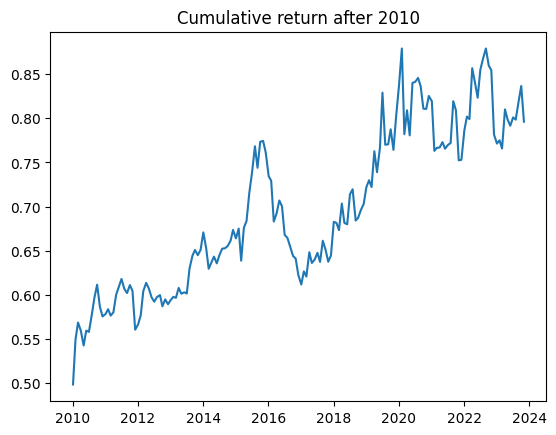

In [72]:
# Find the first date after 2010
first_date = None
for date in dates_holder:
    if date.year >= 2010:
        first_date = date
        break

# Find the index of the first date
first_index = dates_holder.index(first_date)

dates_after_2010 = dates_holder[first_index:]
strategy_monthly_return_holder_after_2010 = strategy_monthly_return_holder[first_index:]

sharpe = np.mean(strategy_monthly_return_holder_after_2010) / np.std(strategy_monthly_return_holder_after_2010) * np.sqrt(12)

print(f'Sharpe ratio after 2010: {sharpe:4f}')

plt.plot(dates_after_2010, strategy_monthly_return_holder_cum[first_index:])
plt.title('Cumulative return after 2010')
plt.show()


# Is there a way to make this results better?

Let's try optimizing the portfolio each month and change the weights. In that case, it's possible to have a better result.

MPT is the classical method to handle it, let's use it.

Sharpe ratio after 2010 with optimization: 0.518973


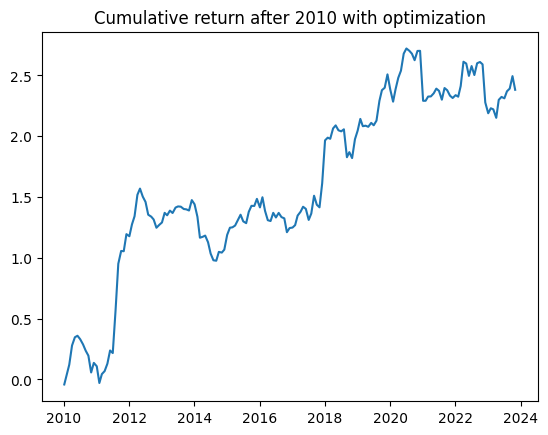

In [73]:
from scipy.optimize import minimize

def objective_function(weights):
    return np.dot(weights.T, np.dot(covariance_matrix, weights))

def constraint_function(weights):
    return np.dot(weights, expected_returns_for_opt) - target_return

monthly_return_holder = []
for date in long_df.index:

    this_month_returns = []
    if date not in next_month_return_df.index:
        continue

    if date.year < 2010:
        continue

    rolling_12_returns_long = long_df.loc[date].dropna()
    rolling_12_returns_short = short_df.loc[date].dropna()

    ticker_to_long = long_df_symbols[date]
    ticker_to_short = short_df_symbols[date]

    next_month_returns_long = next_month_return_df.loc[date, ticker_to_long]
    next_month_returns_short = next_month_return_df.loc[date, ticker_to_short]

    ticker_to_have_position = ticker_to_long + ticker_to_short

    past_returns = monthly_return_df.loc[:date, ticker_to_have_position].iloc[-48:]
    past_returns.fillna(0, inplace=True)

    # The multiplication by -1 is because we are shorting the stocks
    # We use the rolling 12 months return as the expected return because we are using the past 12 months to predict the next month
    # And based on the theory, we are using the past 12 months to predict the next month, with a linear regression
    # It means, our expectation for the next month return is a coefficient times the past 12 months return
    expected_returns_for_opt = rolling_12_returns_long.tolist() + rolling_12_returns_short.tolist()
    covariance_matrix = past_returns.cov()

    # Optimize the weights of the portfolio
    target_return = 0.0
    n_assets = len(expected_returns_for_opt)

    initial_guess = np.ones(n_assets) / n_assets  # Equal-weighted portfolio as initial guess

    bounds = [(0.0, 1) for _ in range(len(ticker_to_long))] + \
            [(-1, -0.0) for _ in range(len(ticker_to_short))]
    constraints = {'type': 'eq', 'fun': constraint_function}

    # Solve the optimization problem
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    optimal_weights = optimal_weights / np.sum(np.abs(optimal_weights))

    # Get the next month returns with the optimal weights
    expected_returns_for_sim = next_month_returns_long.tolist() + next_month_returns_short.tolist()

    next_month_return_with_optimal_weights = np.dot(optimal_weights, expected_returns_for_sim)
    monthly_return_holder.append(next_month_return_with_optimal_weights)

sharpe = np.mean(monthly_return_holder) / np.std(monthly_return_holder) * np.sqrt(12)

print(f'Sharpe ratio after 2010 with optimization: {sharpe:4f}')

plt.plot(dates_after_2010, np.cumsum(np.array(monthly_return_holder)))
plt.title('Cumulative return after 2010 with optimization')
plt.show()